### Author Name: Arnab Mandal

# 🧩 DeepLure Research – 2nd Round Technical Assignment  
**Role:** AI Engineer Candidate  
**Duration:** 24 hours (1 day)  
**Tools:** You are free to use any AI tool or library of your choice (we recommend exploring *Antigravity by Google* if useful).  

---

## 📌 Problem Statement  

In the **previous round**, you derived an analytical solution for **Peak vRAM usage** of the `stable-diffusion-v1-5/stable-diffusion-v1-5` model. Through that exercise, you should now have a solid understanding of:  
- The pipeline composition (`UNet`, `VAE`, and `CLIP` text encoder).  
- The architecture and implementation details of each component.  

This next assignment is a **natural extension** of that work. Your task is to **refactor and reconstruct the pipeline** in a simplified, modular form.  

---

## 🎯 Objectives  

1. **Refactor HuggingFace Codebase**  
   - Extract the model class definitions from the HuggingFace implementation.  
   - You should end up with **three Python classes**:  
     - `UNet`  
     - `CLIP`  
     - `VAE`  
   - Each class must inherit from `torch.nn.Module`.  

2. **Reconstruct the Inference Pipeline**  
   - Implement a single Python method, e.g. `inference(**kwargs)`, that wires these components together to perform inference.  
   - The pipeline should accept text prompts and generate outputs in the same way as the HuggingFace pipeline.  

3. **Model Initialization**  
   - Use **model checkpoints from HuggingFace** to initialize your pipeline.  
   - You may introduce dependencies on secondary packages (e.g., `safetensors`, etc.) if needed.  
   - **Restriction:** Do **not** use out-of-the-box pipeline implementations available in `diffusers`, `transformers`, or similar packages.  

---

## 🔍 Evaluation Criteria  

1. **Determinism**  
   - Eliminate all randomness by setting fixed seeds for every random-number generator used (`torch`, `numpy`, Python’s `random`, etc.).  
   - Your pipeline must produce reproducible results across runs.  

2. **Output Comparability**  
   - Run your reconstructed pipeline with the **same inputs** as the HuggingFace pipeline.  
   - The outputs must be **comparable** (numerically or visually) to HuggingFace results, assuming step 1 is correctly implemented.  

3. **Code Quality**  
   - Clean, modular, and well-documented code.  
   - Clear separation of concerns between model definitions and pipeline orchestration.  

4. **Submission Deliverables**  
   - A single IPython notebook containing:  
     - Class definitions (`UNet`, `CLIP`, `VAE`).  
     - The `inference(**kwargs)` method.  
     - A short comparison test against HuggingFace pipeline outputs.  
     - Any assumptions made.  

---

## Notes  

- You are free to use **any AI tool or library** to assist you (e.g., *Antigravity by Google*).  
- For **GPU access**, you may try out **Google Colab (Free Tier)** or **Kaggle (Free Tier)**.  
- Treat this as if you were building a **minimal but reliable research pipeline** for internal use.  


---
### INDEX FOR RELEVANT SECTIONS OF NOTEBOOOK
1. [VAE](#vae-architecture)
2. [CLIP](##CLIP-Encoder)
3. [U-Net](##U-Net-architecture)
3. [Inference Function](##COMPLETE-INFERENCE-FUNCTION)
4. [Comparison class for viewing images and comparing visually and analytically](#Final-Comparison-Class)
---

In [1]:
# # For convenience, we've included the code snippet from first-round interview
# pip install torch torchvision diffusers['torch'] transformers accelerate

import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline = pipeline.to("cuda" if torch.cuda.is_available() else "cpu")

pipeline.enable_model_cpu_offload()

pipeline.enable_xformers_memory_efficient_attention()

# prepare image
img_src = [{
    "url": "./data/balloon--low-res.jpeg",
    "prompt": "aerial view, colorful hot air balloon, lush green forest canopy, springtime, warm climate, vibrant foliage, soft sunlight, gentle shadow, white birds flying alongside, harmony, freedom, bright natural colors, serene atmosphere, highly detailed, realistic, photorealistic, cinematic lighting"
}]
# + [{
#     'url': "./data/bench--high-res.jpg",
#     'prompt': "photorealistic, high resolution, realistic lighting, natural shadows, detailed textures, lush green grass, wooden bench with grain detail, expansive valley, agricultural fields, blue-toned mountains, fluffy cumulus clouds, wispy cirrus clouds, bright blue sky, clear sunny day, soft sunlight, tranquil atmosphere, cinematic realism"
# }, {
#     'url': "./data/groceries--low-res.jpg",
#     'prompt': "cartoon style, bold outlines, simplified shapes, vibrant colors, playful atmosphere, exaggerated proportions, stylized SUV trunk, whimsical paper grocery bags, fresh produce with bright highlights, baguette with cartoon detail, cheerful parking area, greenery with simplified textures, sunny day, lighthearted mood, 2D illustration, animated landscape aesthetic"
# }, {
#     'url': "./data/truck--high-res.jpg",
#     'prompt': "Michelangelo style, Renaissance painting, classical composition, rich earthy tones, detailed brushwork, divine atmosphere, expressive lighting, monumental presence, artistic grandeur, fresco-inspired texture, high contrast shadows, timeless aesthetic"
# }]

results = list()

# This for loop is meant to demonstrate that the models' vRAM usage depends
# on Image-size and prompt length (among other factors). You may observe the
# vRAM usage while the model is running by executing the following command
# in a separate terminal and monitoring the changes in vRAM usage:
#    ```shell
#    watch -n 1.0 nvidia-smi
#    ```
#
# You may modify this for loop according to your needs.
for _src in img_src:
    init_image = load_image(_src.get('url'))
    prompt = _src.get('prompt')

    # pass prompt and image to pipeline
    image = pipeline(prompt, image=init_image, guidance_scale=5.0).images[0]
    results.append(make_image_grid([init_image, image], rows=1, cols=2))

results[0].show()

/home/arnab/miniconda3/envs/deepLure/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 40/40 [00:04<00:00,  9.13it/s]


In [2]:
import os

os.makedirs("output", exist_ok=True)

for i, res in enumerate(results):
    res.save(f"./output/result_{i}.png")

Gtk-Message: 23:34:32.494: Failed to load module "appmenu-gtk-module"


---

### MODEL ARCHITECTURE

All necessary imports, libraries, and configuration+verifications

In [3]:
import os
import random
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDPMScheduler
from PIL import Image
import torch
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

# cuda torch verification
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

SEED=42
WIDTH=512
HEIGHT=512
LATENTS_WIDTH=WIDTH//8
LATENTS_HEIGHT=HEIGHT//8

/usr/local/bin/swappy: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


True
0
NVIDIA GeForce RTX 4060 Laptop GPU


Seeding all random selectors

In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False  # To ensure cuDNN picks the same kernel every time, instead of profiling all kernels and then picking the fastest
torch.use_deterministic_algorithms=True

In [5]:
def rescale(x, old_range, new_range, clamp=False):
    """
    Rescales a tensor from one range to another
    """
    old_min, old_max=old_range
    new_min, new_max=new_range

    x-=old_min
    x*=(new_max-new_min)/(old_max-old_min)

    x+=new_min
    if clamp:
        x=x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    """
    Generates a time embedding for a given timestep.
    """
    freqs=torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32)/160)
    x=torch.tensor([timestep], dtype=torch.float32)[:, None]*freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [6]:
class UpSample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        return self.conv(x)

In [7]:
class SelfAttention(nn.Module):
    """
    - Self attention allows a model to focus on different parts of the input sequence while processing each element.
    - multi-head attention via the n_heads allows the model to focus on different dimensions of the sequence simultaneously.
    - Basically learns relationships within a sequence
    """
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()

        #combining qkv matrices into one
        self.in_proj=nn.Linear(d_embed, 3*d_embed, bias=in_proj_bias)

        #output matrix from qkv values
        self.out_proj=nn.Linear(d_embed, d_embed, bias=out_proj_bias)

        self.n_heads=n_heads
        self.d_head=d_embed//n_heads
    
    def forward(self, x, causal_mask=False):
        input_shape=x.shape
        batch_size, sequence_length, d_embed=input_shape
        
        interim_shape=(batch_size, sequence_length, self.n_heads, self.d_head)
        q, k, v=self.in_proj(x).chunk(3, dim=-1)

        q=q.view(interim_shape).transpose(1,2)
        k=k.view(interim_shape).transpose(1,2)
        v=v.view(interim_shape).transpose(1,2)

        weight=q@k.transpose(-1, -2)

        if causal_mask:
            # upper triangular mask of 1s, rest -infinities
            mask=torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)
        
        weight/=math.sqrt(self.d_head)
        weight=F.softmax(weight, dim=-1)

        output=weight@v

        output=output.transpose(1,2)
        output=output.reshape(input_shape)
        output=self.out_proj(output)

        return output

In [8]:
class CrossAttention(nn.Module):
    """
    - Learns a relationship between two sequences
    - had to modify because of failed run
    """
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)

        self.o_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        
        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        q = q.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(batch_size, -1, self.n_heads, self.d_head).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        output = output.view(input_shape)
        
        output = self.o_proj(output)

        return output

In [9]:
class VAE_AttentionBlock(nn.Module):
    """
    Self Attention block to allow model to focus on different parts on the input feature map.
    """
    def __init__(self, channels):
        super().__init__()
        self.group_norm=nn.GroupNorm(32, channels)
        self.attention=SelfAttention(1, channels)
    
    def forward(self, x):
        residue=x

        x=self.group_norm(x)
        n, c, h, w=x.shape
        x=x.view((n, c, h*w)) #transpose to apply self attention
        x=x.transpose(-1, -2)

        #self attention without mask
        x=self.attention(x)

        x=x.transpose(-1, -2)
        x=x.view((n, c, h, w))

        x+=residue

        return x

In [10]:
class VAE_ResidualBlock(nn.Module):
    """
    Allows gradient to flow through shortcut connections, helps in training deep nets.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.group_norm_1=nn.GroupNorm(32, in_channels)
        self.conv_1=nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        
        self.group_norm_2=nn.GroupNorm(32, out_channels)
        self.conv_2=nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels==out_channels:
            self.residual_layer=nn.Identity()
        else:
            self.residual_layer=nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0) #to match input output dimensions
    
    def forward(self, x):
        residue=x

        x=self.group_norm_1(x)
        x=F.silu(x)
        x=self.conv_1(x)

        x=self.group_norm_2(x)
        x=F.silu(x)
        x=self.conv_2(x)

        return x+self.residual_layer(residue)

---

## VAE Architecture

In [11]:
class VAE_Encoder(nn.Module):
    """
    - Includes refactor from nn.Sequential to nn.Module
    - Trained to learn mean and variance of the distribution
    - Sequence of submodels.
    - Each submodel reduces the dimensionality of data, while increasing the number of features, i.e. number of pixels reduces but information stored by each pixel increases.

    Returns:
        x: Sample from the learnt gaussian distribution
    """
    def __init__(self):
        super().__init__()

        self.layers=nn.Sequential(
            #conv layer
            nn.Conv2d(3, 128, kernel_size=3, padding=1),

            #residual layers
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),

            #conv layer for approximately downsampling by 1/2
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),

            #residual layers
            VAE_ResidualBlock(128, 256),
            VAE_ResidualBlock(256, 256),

            #conv layer for downsampling again
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),

            #residual layers
            VAE_ResidualBlock(256, 512),
            VAE_ResidualBlock(512, 512),

            #conv layer for downsampling again
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),

            #residual layers
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),

            VAE_AttentionBlock(512),

            VAE_ResidualBlock(512, 512),

            nn.GroupNorm(32, 512),

            #author proven that Sigmoid Linear Unit works better here
            nn.SiLU(),

            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            nn.Conv2d(8, 8, kernel_size=1, padding=0)
        )
    
    def forward(self, x:torch.Tensor, noise:torch.Tensor)->torch.Tensor:
        for module in self.layers:
            if getattr(module, 'stride', None)==(2,2):
                #asymetric padding for conv layers with stride 2 to ensure accurate downsampling by 1/2
                x=F.pad(x, (0, 1, 0, 1))
            x=module(x)
        
        #obtaining mean and variance of the multivariate gaussian distribution
        mean, log_variance=torch.chunk(x, 2, dim=1)
        log_variance=torch.clamp(log_variance, -30, 20)
        variance=log_variance.exp()
        std_dev=variance.sqrt()

        #sampling
        x=mean+std_dev*noise

        #scaling factor used by authors
        x*=0.18215

        return x

In [12]:
class VAE_Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(
            # [0] Post Quant Conv (4 -> 4)
            nn.Conv2d(4, 4, kernel_size=1, padding=0),
            
            # [1] Conv In (4 -> 512)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # [2-4] Mid Block (Remains 512)
            VAE_ResidualBlock(512, 512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),

            # [5-8] Up Block 3 (512 -> 512)
            # This block exists in your previous code
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            UpSample(512),

            # [9-12] Up Block 2 (512 -> 512) 
            # *** THIS IS THE MISSING BLOCK FROM YOUR CODE ***
            # The weights at this depth still expect 512 input/output
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            UpSample(512),

            # [13-16] Up Block 1 (512 -> 256)
            # Now we finally step down to 256
            VAE_ResidualBlock(512, 256),
            VAE_ResidualBlock(256, 256),
            VAE_ResidualBlock(256, 256),
            UpSample(256),

            # [17-19] Up Block 0 (256 -> 128)
            VAE_ResidualBlock(256, 128),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),

            # [20-22] Output
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # Scaling factor used in SD 1.5 training
        x /= 0.18215
        x = self.layers(x)
        return x

---
## CLIP Encoder

In [13]:
class CLIPEmbedding(nn.Module):
    """
    - Converts text to embeddings combining token embeddings and positional embeddings
    """
    def __init__(self, n_vocab, n_embed, n_token):
        super().__init__()
        self.token_embedding=nn.Embedding(n_vocab, n_embed)
        self.position_embedding=nn.Parameter(torch.zeros((n_token, n_embed)))
    
    def forward(self, tokens):
        x=self.token_embedding(tokens)
        x+=self.position_embedding
        
        return x

In [14]:
class CLIPLayer(nn.Module):
    """
    - Single layer consisting of self attention adn then a feed forward neural network
    """
    def __init__(self, n_head, n_emb):
        super().__init__()

        self.layer_norm_1=nn.LayerNorm(n_emb)
        self.attention=SelfAttention(n_head, n_emb)
        
        self.layer_norm_2=nn.LayerNorm(n_emb)

        #feed forward
        self.linear_1=nn.Linear(n_emb, 4*n_emb)
        self.linear_2=nn.Linear(4*n_emb, n_emb)
    
    def forward(self, x):
        residue=x
        
        x=self.layer_norm_1(x)
        x=self.attention(x, causal_mask=True)
        
        x+=residue
        residue=x

        x=self.layer_norm_2(x)
        x=self.linear_1(x)

        #QuickGELU
        x=x*torch.sigmoid(1.702*x)
        x=self.linear_2(x)
        
        x+=residue
        return x

In [15]:
class CLIP(nn.Module):
    """
    - Stacks multiple CLIPLayers to form a deep neural net.
    """
    def __init__(self):
        super().__init__()
        self.embedding=CLIPEmbedding(49408, 768, 77)
        self.layers=nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)
        ])

        self.layernorm=nn.LayerNorm(768)
    
    def forward(self, tokens):
        tokens=tokens.type(torch.long)
        state=self.embedding(tokens)
        
        for layer in self.layers:
            state=layer(state)
        output=self.layernorm(state)

        return output

---
## U-Net architecture

In [16]:
class TimeEmbedding(nn.Module):
    """
    Encode time to condition model on time step during diffusion process
    """
    def __init__(self, n_emb):
        super().__init__()
        self.linear_1=nn.Linear(n_emb, 4*n_emb)
        self.linear_2=nn.Linear(4*n_emb, 4*n_emb)
    
    def forward(self, x):
        x=self.linear_1(x)
        x=F.silu(x)
        x=self.linear_2(x)
        return x

In [17]:
class UNET_ResidualBlock(nn.Module):
    """
    Incorporates time embeddings in the residual blocks processing feature maps
    """
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.group_norm_feature=nn.GroupNorm(32, in_channels)
        self.conv_feature=nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time=nn.Linear(n_time, out_channels)

        self.group_norm_merged=nn.GroupNorm(32, out_channels)
        self.conv_merged=nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels==out_channels:
            self.residual_layer=nn.Identity()
        
        else:
            self.residual_layer=nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        residue=feature
        feature=self.group_norm_feature(feature)
        feature=F.silu(feature)

        feature=self.conv_feature(feature)
        time=F.silu(time)
        time=self.linear_time(time)
        merged=feature+time.unsqueeze(-1).unsqueeze(-1)

        merged=self.group_norm_merged(merged)
        merged=F.silu(merged)
        merged=self.conv_merged(merged)

        return merged+self.residual_layer(residue)

In [18]:
class UNET_AttentionBlock(nn.Module):
    """
    - Integrates layers of self attention and cross attention.
    - Integrates self attention to itself after reshaping.
    - Then cross attention to the contexts from text embeddings.
    """
    def __init__(self, n_head, n_emb, d_context=768):
        super().__init__()
        channels=n_head*n_emb

        self.group_norm=nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input=nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layer_norm_1=nn.LayerNorm(channels)
        self.attention_1=SelfAttention(n_head, channels, in_proj_bias=False)

        self.layer_norm_2=nn.LayerNorm(channels)
        self.attention_2=CrossAttention(n_head, channels, d_context, in_proj_bias=False)

        self.layer_norm_3=nn.LayerNorm(channels)

        self.linear_geglu_1=nn.Linear(channels, 4*channels*2)
        self.linear_geglu_2=nn.Linear(4*channels, channels)

        self.conv_output=nn.Conv2d(channels, channels, kernel_size=1, padding=0)
    
    def forward(self, x, context):
        residue_long=x

        x=self.group_norm(x)
        x=self.conv_input(x)

        n, c, h, w=x.shape

        x=x.view((n, c, h*w))
        x=x.transpose(-1, -2)

        residue_short=x
        
        #normalisation with self attention and skip connection
        x=self.layer_norm_1(x)
        x=self.attention_1(x)

        x+=residue_short
        residue_short=x

        #normalization with cross attention and skip connection
        x=self.layer_norm_2(x)
        x=self.attention_2(x, context)

        x+=residue_short
        residue_short=x

        #normalisation with feedforward net, GeGLU and skip connection
        x=self.layer_norm_3(x)
        x, gate=self.linear_geglu_1(x).chunk(2, dim=-1)
        x=x*F.gelu(gate)
        x=self.linear_geglu_2(x)
        x+=residue_short

        x=x.transpose(-1, -2)
        x=x.view((n, c, h, w))

        return self.conv_output(x)+residue_long

In [19]:
class SwitchSequential(nn.Sequential):
    """
    Applies layers conditionally based on type
    """
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x=layer(x, context)
            
            elif isinstance(layer, UNET_ResidualBlock):
                x=layer(x, time)
            
            else:
                x=layer(x)
        return x

In [20]:
class UNET(nn.Module):
    """
    Consists of encoder, bottleneck and decoder.

    - Encoder:
        - Downsample input feature maps while increasing the number of channels
    - Bottleneck:
        - Processes the feature maps at the lowest resolution.
    - Decoder:
        - Upsamples feature maps while decreasing the number of channels.
    """
    def __init__(self):
        super().__init__()
        self.encoders=nn.ModuleList([
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),

            SwitchSequential(nn.Conv2d(320, 320, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(320, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),

            SwitchSequential(nn.Conv2d(640, 640, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(640, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280), UNET_AttentionBlock(8, 160)),

            SwitchSequential(nn.Conv2d(1280, 1280, kernel_size=3, stride=2, padding=1)),

            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
            SwitchSequential(UNET_ResidualBlock(1280, 1280)),
        ])
        
        self.bottleneck=SwitchSequential(
            UNET_ResidualBlock(1280, 1280),
            UNET_AttentionBlock(8, 160),
            UNET_ResidualBlock(1280, 1280),
        )

        self.decoders=nn.ModuleList([
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280)),

            SwitchSequential(UNET_ResidualBlock(2560, 1280), UpSample(1280)),

            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),
            SwitchSequential(UNET_ResidualBlock(2560, 1280), UNET_AttentionBlock(8, 160)),

            SwitchSequential(UNET_ResidualBlock(1920, 1280), UNET_AttentionBlock(8, 160), UpSample(1280)),
            SwitchSequential(UNET_ResidualBlock(1920, 640), UNET_AttentionBlock(8, 80)),
            SwitchSequential(UNET_ResidualBlock(1280, 640), UNET_AttentionBlock(8, 80)),

            SwitchSequential(UNET_ResidualBlock(960, 640), UNET_AttentionBlock(8, 80), UpSample(640)),
            SwitchSequential(UNET_ResidualBlock(960, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])
    
    def forward(self, x, context, time):
        skip_connections=[]
        for layers in self.encoders:
            x=layers(x, context, time)
            skip_connections.append(x)
        
        x=self.bottleneck(x, context, time)

        for layers in self.decoders:
            x=torch.cat((x, skip_connections.pop()), dim=1)
            x=layers(x, context, time)
        
        return x

In [21]:
class UNET_OutPutLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.group_norm=nn.GroupNorm(32, in_channels)
        self.conv=nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x=self.group_norm(x)
        x=F.silu(x)

        x=self.conv(x)
        return x

In [22]:
class Diffusion(nn.Module):
    """
    Combines time embeddings, processes the latent representation and context conditioned on time embeddings to produce the final output of the diffusion model.
    """
    def __init__(self):
        super().__init__()
        self.time_embedding=TimeEmbedding(320)
        self.unet=UNET()
        self.final=UNET_OutPutLayer(320, 4)

    def forward(self, latent, context, time):
        time=self.time_embedding(time)
        output=self.unet(latent, context, time)
        output=self.final(output)
        return output

---
## Scheduler

In [23]:
class DDPMSampler:
    def __init__(self, generator: torch.Generator, num_training_steps=1000, beta_start=0.00085, beta_end=0.0120):
        self.betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_training_steps, dtype=torch.float32)**2
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)

        self.generator = generator
        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep):
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t
    
    def _get_variance(self, timestep):
        prev_t = self._get_previous_timestep(timestep)
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # For t > 0, computation is standard. For t=0, variance is 0.
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
        variance = torch.clamp(variance, min=1e-20)
        return variance

    def set_strength(self, strength=1):
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step

    def step(self, timestep, latents, model_output):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t
        
        # --- FIXED FORMULA AS OF EQUATION 10 FROM APPER

        pred_original_sample_coeff = (1 - current_alpha_t) / (1 - alpha_prod_t) ** 0.5
        
        pred_prev_sample_direction = (latents - pred_original_sample_coeff * model_output) / (current_alpha_t ** 0.5)

        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)
            variance = (self._get_variance(t) ** 0.5) * noise
            
        pred_prev_sample = pred_prev_sample_direction + variance
        return pred_prev_sample
    
    def add_noise(self, original_samples, timesteps):
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()

        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

---
## COMPLETE INFERENCE FUNCTION

In [24]:
def inference(prompt, uncond_prompt=None, input_image=None, strength=0.8, do_cfg=True, cfg_scale=7.5, sampler_name="ddpm", n_inference_steps=50, models={}, device=None, idle_device=None, tokenizer=None):
    """
    Handles text encoding, latent space manipulation, diffusion_sampling and image decoding

    Args:
        prompt: The text prompt for image generation
        uncond_prompt: the unconditional prompt used for cfg classifier free guidance
        strength: Controls amoutn of noise added to input image used in image to image traslation
        ..etc
    """
    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("Strength must be between 0 and 1")

        if idle_device:
            to_idle=lambda x: x.to(idle_device)
        else:
            to_idle=lambda x: x
        
        generator=torch.Generator(device=device)
        generator.manual_seed(SEED)

        clip=models["clip"]
        clip.to(device)

        if do_cfg:
            cond_tokens=tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
            cond_tokens=torch.tensor(cond_tokens, dtype=torch.long, device=device)
            cond_context=clip(cond_tokens)

            uncond_tokens=tokenizer.batch_encode_plus([uncond_prompt], padding="max_length", max_length=77).input_ids
            uncond_tokens=torch.tensor(uncond_tokens, dtype=torch.long, device=device)
            uncond_context=clip(uncond_tokens)
            
            context=torch.cat([cond_context, uncond_context])
        else:
            tokens=tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=77).input_ids
            tokens=torch.tensor(tokens, dtype=torch.long, device=device)
            context=clip(tokens)
        
        to_idle(clip)

        if sampler_name=="ddpm":
            sampler=DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError(f"Unknown sampler {sampler_name}")
        
        latents_shape=(1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        if input_image:
            encoder = models["encoder"]
            encoder.to(device)
            to_idle(encoder)
        else:
            latents = torch.randn(latents_shape, generator=generator, device=device)

        diffusion=models["diffusion"]
        diffusion.to(device)

        timesteps = tqdm(sampler.timesteps)
        for i, timestep in enumerate(timesteps):
            time_embedding = get_time_embedding(timestep).to(device)

            model_input = latents

            if do_cfg:
                model_input = model_input.repeat(2, 1, 1, 1)

            model_output = diffusion(model_input, context, time_embedding)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

            latents = sampler.step(timestep, latents, model_output)
            
            # Added NaN check after red-black noise explosion
            if torch.isnan(latents).any():
                print(f"NaN detected, model exploding")
                to_idle(diffusion)
                return None # Exit early

        to_idle(diffusion)

        decoder = models["decoder"]
        decoder.to(device)
        
        # CLAMP TO -5, 5 BEFORE DECODING FOR VAE TO PREVENT EXPLOSION
        latents = latents.clamp(-5, 5) 
        
        images = decoder(latents)
        to_idle(decoder)

        images = rescale(images, (-1, 1), (0, 255), clamp=True)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()
        
        return images[0]

---
Loading weights via model loader code

In [25]:
import torch
from safetensors.torch import load_file
from pathlib import Path
from transformers import CLIPTokenizer

def load_from_standard_weights(ckpt_path, device):
    if Path(ckpt_path).exists():
        if ckpt_path.endswith('.safetensors'):
            state_dict = load_file(ckpt_path, device=str(device))
        else:
            checkpoint = torch.load(ckpt_path, map_location=device)
            state_dict = checkpoint.get("state_dict", checkpoint)
    else:
        from diffusers import StableDiffusionPipeline
        
        pipe = StableDiffusionPipeline.from_pretrained(
            ckpt_path,
            torch_dtype=torch.float32,
            use_safetensors=True
        )
        
        vae_state = pipe.vae.state_dict()
        unet_state = pipe.unet.state_dict()
        text_encoder_state = pipe.text_encoder.state_dict()
        
        return {
            'encoder': convert_vae_encoder(vae_state),
            'decoder': convert_vae_decoder(vae_state),
            'diffusion': convert_unet(unet_state),
            'clip': convert_clip(text_encoder_state),
        }
    
    return {
        'encoder': extract_and_convert_encoder(state_dict),
        'decoder': extract_and_convert_decoder(state_dict),
        'diffusion': extract_and_convert_unet(state_dict),
        'clip': extract_and_convert_clip(state_dict),
    }

def convert_vae_encoder(vae_state):
    encoder_state = {}
    
    if 'encoder.mid_block.attentions.0.to_q.weight' in vae_state:
        q_w = vae_state['encoder.mid_block.attentions.0.to_q.weight']
        k_w = vae_state['encoder.mid_block.attentions.0.to_k.weight']
        v_w = vae_state['encoder.mid_block.attentions.0.to_v.weight']
        encoder_state['layers.13.attention.in_proj.weight'] = torch.cat([q_w, k_w, v_w], dim=0)
        
        q_b = vae_state['encoder.mid_block.attentions.0.to_q.bias']
        k_b = vae_state['encoder.mid_block.attentions.0.to_k.bias']
        v_b = vae_state['encoder.mid_block.attentions.0.to_v.bias']
        encoder_state['layers.13.attention.in_proj.bias'] = torch.cat([q_b, k_b, v_b], dim=0)
        
        encoder_state['layers.13.attention.out_proj.weight'] = vae_state['encoder.mid_block.attentions.0.to_out.0.weight']
        encoder_state['layers.13.attention.out_proj.bias'] = vae_state['encoder.mid_block.attentions.0.to_out.0.bias']
        encoder_state['layers.13.group_norm.weight'] = vae_state['encoder.mid_block.attentions.0.group_norm.weight']
        encoder_state['layers.13.group_norm.bias'] = vae_state['encoder.mid_block.attentions.0.group_norm.bias']

    for key, value in vae_state.items():
        if 'mid_block.attentions.0.' in key: continue
        if not key.startswith('encoder.'): continue
        
        new_key = None
        
        if key.startswith('encoder.conv_in.'): new_key = key.replace('encoder.conv_in.', 'layers.0.')
        elif 'down_blocks.0.resnets.0.' in key: new_key = key.replace('encoder.down_blocks.0.resnets.0.', 'layers.1.')
        elif 'down_blocks.0.resnets.1.' in key: new_key = key.replace('encoder.down_blocks.0.resnets.1.', 'layers.2.')
        elif 'down_blocks.0.downsamplers.0.' in key: new_key = key.replace('encoder.down_blocks.0.downsamplers.0.conv.', 'layers.3.')
        elif 'down_blocks.1.resnets.0.' in key: new_key = key.replace('encoder.down_blocks.1.resnets.0.', 'layers.4.')
        elif 'down_blocks.1.resnets.1.' in key: new_key = key.replace('encoder.down_blocks.1.resnets.1.', 'layers.5.')
        elif 'down_blocks.1.downsamplers.0.' in key: new_key = key.replace('encoder.down_blocks.1.downsamplers.0.conv.', 'layers.6.')
        elif 'down_blocks.2.resnets.0.' in key: new_key = key.replace('encoder.down_blocks.2.resnets.0.', 'layers.7.')
        elif 'down_blocks.2.resnets.1.' in key: new_key = key.replace('encoder.down_blocks.2.resnets.1.', 'layers.8.')
        elif 'down_blocks.2.downsamplers.0.' in key: new_key = key.replace('encoder.down_blocks.2.downsamplers.0.conv.', 'layers.9.')
        elif 'down_blocks.3.resnets.0.' in key: new_key = key.replace('encoder.down_blocks.3.resnets.0.', 'layers.10.')
        elif 'down_blocks.3.resnets.1.' in key: new_key = key.replace('encoder.down_blocks.3.resnets.1.', 'layers.11.')
        elif 'mid_block.resnets.0.' in key: new_key = key.replace('encoder.mid_block.resnets.0.', 'layers.12.')
        elif 'mid_block.resnets.1.' in key: new_key = key.replace('encoder.mid_block.resnets.1.', 'layers.14.')
        
        elif 'norm_out' in key:
            new_key = 'layers.15.' + key.split('.')[-1]
            
        elif key.startswith('encoder.conv_out.'): 
            new_key = key.replace('encoder.conv_out.', 'layers.17.')
        
        if new_key:
            new_key = new_key.replace('norm1.', 'group_norm_1.')
            new_key = new_key.replace('norm2.', 'group_norm_2.')
            new_key = new_key.replace('conv1.', 'conv_1.')
            new_key = new_key.replace('conv2.', 'conv_2.')
            new_key = new_key.replace('conv_shortcut.', 'residual_layer.')
            encoder_state[new_key] = value
            
    if 'encoder.quant_conv.weight' in vae_state:
        encoder_state['layers.18.weight'] = vae_state['encoder.quant_conv.weight']
        encoder_state['layers.18.bias'] = vae_state['encoder.quant_conv.bias']
    elif 'quant_conv.weight' in vae_state: 
        encoder_state['layers.18.weight'] = vae_state['quant_conv.weight']
        encoder_state['layers.18.bias'] = vae_state['quant_conv.bias']

    return encoder_state

def convert_vae_decoder(vae_state):
    decoder_state = {}
    
    if 'decoder.mid_block.attentions.0.to_q.weight' in vae_state:
        q_w = vae_state['decoder.mid_block.attentions.0.to_q.weight']
        k_w = vae_state['decoder.mid_block.attentions.0.to_k.weight']
        v_w = vae_state['decoder.mid_block.attentions.0.to_v.weight']
        decoder_state['layers.3.attention.in_proj.weight'] = torch.cat([q_w, k_w, v_w], dim=0)
        
        q_b = vae_state['decoder.mid_block.attentions.0.to_q.bias']
        k_b = vae_state['decoder.mid_block.attentions.0.to_k.bias']
        v_b = vae_state['decoder.mid_block.attentions.0.to_v.bias']
        decoder_state['layers.3.attention.in_proj.bias'] = torch.cat([q_b, k_b, v_b], dim=0)
        
        decoder_state['layers.3.attention.out_proj.weight'] = vae_state['decoder.mid_block.attentions.0.to_out.0.weight']
        decoder_state['layers.3.attention.out_proj.bias'] = vae_state['decoder.mid_block.attentions.0.to_out.0.bias']
        decoder_state['layers.3.group_norm.weight'] = vae_state['decoder.mid_block.attentions.0.group_norm.weight']
        decoder_state['layers.3.group_norm.bias'] = vae_state['decoder.mid_block.attentions.0.group_norm.bias']

    for key, value in vae_state.items():
        if 'mid_block.attentions.0.' in key: continue
        if not key.startswith('decoder.'): continue
        
        new_key = None
        if key.startswith('decoder.conv_in.'): new_key = key.replace('decoder.conv_in.', 'layers.1.')
        elif 'mid_block.resnets.0.' in key: new_key = key.replace('decoder.mid_block.resnets.0.', 'layers.2.')
        elif 'mid_block.resnets.1.' in key: new_key = key.replace('decoder.mid_block.resnets.1.', 'layers.4.')
        elif 'up_blocks.0.resnets.0.' in key: new_key = key.replace('decoder.up_blocks.0.resnets.0.', 'layers.5.')
        elif 'up_blocks.0.resnets.1.' in key: new_key = key.replace('decoder.up_blocks.0.resnets.1.', 'layers.6.')
        elif 'up_blocks.0.resnets.2.' in key: new_key = key.replace('decoder.up_blocks.0.resnets.2.', 'layers.7.')
        elif 'up_blocks.0.upsamplers.0.' in key: new_key = key.replace('decoder.up_blocks.0.upsamplers.0.conv.', 'layers.8.conv.')
        elif 'up_blocks.1.resnets.0.' in key: new_key = key.replace('decoder.up_blocks.1.resnets.0.', 'layers.9.')
        elif 'up_blocks.1.resnets.1.' in key: new_key = key.replace('decoder.up_blocks.1.resnets.1.', 'layers.10.')
        elif 'up_blocks.1.resnets.2.' in key: new_key = key.replace('decoder.up_blocks.1.resnets.2.', 'layers.11.')
        elif 'up_blocks.1.upsamplers.0.' in key: new_key = key.replace('decoder.up_blocks.1.upsamplers.0.conv.', 'layers.12.conv.')
        elif 'up_blocks.2.resnets.0.' in key: new_key = key.replace('decoder.up_blocks.2.resnets.0.', 'layers.13.')
        elif 'up_blocks.2.resnets.1.' in key: new_key = key.replace('decoder.up_blocks.2.resnets.1.', 'layers.14.')
        elif 'up_blocks.2.resnets.2.' in key: new_key = key.replace('decoder.up_blocks.2.resnets.2.', 'layers.15.')
        elif 'up_blocks.2.upsamplers.0.' in key: new_key = key.replace('decoder.up_blocks.2.upsamplers.0.conv.', 'layers.16.conv.')
        elif 'up_blocks.3.resnets.0.' in key: new_key = key.replace('decoder.up_blocks.3.resnets.0.', 'layers.17.')
        elif 'up_blocks.3.resnets.1.' in key: new_key = key.replace('decoder.up_blocks.3.resnets.1.', 'layers.18.')
        elif 'up_blocks.3.resnets.2.' in key: new_key = key.replace('decoder.up_blocks.3.resnets.2.', 'layers.19.')
        
        elif 'norm_out' in key:
             new_key = 'layers.20.' + key.split('.')[-1]
             
        elif key.startswith('decoder.conv_out.'): new_key = key.replace('decoder.conv_out.', 'layers.22.')

        if new_key:
            new_key = new_key.replace('norm1.', 'group_norm_1.')
            new_key = new_key.replace('norm2.', 'group_norm_2.')
            new_key = new_key.replace('conv1.', 'conv_1.')
            new_key = new_key.replace('conv2.', 'conv_2.')
            new_key = new_key.replace('conv_shortcut.', 'residual_layer.')
            decoder_state[new_key] = value
            
    if 'decoder.post_quant_conv.weight' in vae_state:
        decoder_state['layers.0.weight'] = vae_state['decoder.post_quant_conv.weight']
        decoder_state['layers.0.bias'] = vae_state['decoder.post_quant_conv.bias']
    elif 'post_quant_conv.weight' in vae_state: 
        decoder_state['layers.0.weight'] = vae_state['post_quant_conv.weight']
        decoder_state['layers.0.bias'] = vae_state['post_quant_conv.bias']

    return decoder_state

def convert_unet(unet_state):
    diffusion_state = {}
    
    for key, value in unet_state.items():
        new_key = key
        
        if key.startswith('time_embedding.'):
            new_key = 'time_embedding.' + key.split('time_embedding.')[1]
        
        elif key.startswith('conv_in.'):
            new_key = 'unet.encoders.0.0.' + key.split('conv_in.')[1]
        
        elif key.startswith('down_blocks.'):
            parts = key.split('.')
            block_idx = int(parts[1])
            
            if block_idx == 0:
                if 'resnets.0.' in key: new_key = key.replace('down_blocks.0.resnets.0.', 'unet.encoders.1.0.')
                elif 'attentions.0.' in key: new_key = key.replace('down_blocks.0.attentions.0.', 'unet.encoders.1.1.')
                elif 'resnets.1.' in key: new_key = key.replace('down_blocks.0.resnets.1.', 'unet.encoders.2.0.')
                elif 'attentions.1.' in key: new_key = key.replace('down_blocks.0.attentions.1.', 'unet.encoders.2.1.')
                elif 'downsamplers.0.' in key: new_key = key.replace('down_blocks.0.downsamplers.0.conv.', 'unet.encoders.3.0.')
            elif block_idx == 1:
                if 'resnets.0.' in key: new_key = key.replace('down_blocks.1.resnets.0.', 'unet.encoders.4.0.')
                elif 'attentions.0.' in key: new_key = key.replace('down_blocks.1.attentions.0.', 'unet.encoders.4.1.')
                elif 'resnets.1.' in key: new_key = key.replace('down_blocks.1.resnets.1.', 'unet.encoders.5.0.')
                elif 'attentions.1.' in key: new_key = key.replace('down_blocks.1.attentions.1.', 'unet.encoders.5.1.')
                elif 'downsamplers.0.' in key: new_key = key.replace('down_blocks.1.downsamplers.0.conv.', 'unet.encoders.6.0.')
            elif block_idx == 2:
                if 'resnets.0.' in key: new_key = key.replace('down_blocks.2.resnets.0.', 'unet.encoders.7.0.')
                elif 'attentions.0.' in key: new_key = key.replace('down_blocks.2.attentions.0.', 'unet.encoders.7.1.')
                elif 'resnets.1.' in key: new_key = key.replace('down_blocks.2.resnets.1.', 'unet.encoders.8.0.')
                elif 'attentions.1.' in key: new_key = key.replace('down_blocks.2.attentions.1.', 'unet.encoders.8.1.')
                elif 'downsamplers.0.' in key: new_key = key.replace('down_blocks.2.downsamplers.0.conv.', 'unet.encoders.9.0.')
            elif block_idx == 3:
                if 'resnets.0.' in key: new_key = key.replace('down_blocks.3.resnets.0.', 'unet.encoders.10.0.')
                elif 'resnets.1.' in key: new_key = key.replace('down_blocks.3.resnets.1.', 'unet.encoders.11.0.')
        
        elif key.startswith('mid_block.'):
            if 'resnets.0.' in key: new_key = key.replace('mid_block.resnets.0.', 'unet.bottleneck.0.')
            elif 'attentions.0.' in key: new_key = key.replace('mid_block.attentions.0.', 'unet.bottleneck.1.')
            elif 'resnets.1.' in key: new_key = key.replace('mid_block.resnets.1.', 'unet.bottleneck.2.')
        
        elif key.startswith('up_blocks.'):
            parts = key.split('.')
            block_idx = int(parts[1])
            
            if block_idx == 0:
                if 'resnets.0.' in key: new_key = key.replace('up_blocks.0.resnets.0.', 'unet.decoders.0.0.')
                elif 'resnets.1.' in key: new_key = key.replace('up_blocks.0.resnets.1.', 'unet.decoders.1.0.')
                elif 'resnets.2.' in key: new_key = key.replace('up_blocks.0.resnets.2.', 'unet.decoders.2.0.')
                elif 'upsamplers.0.' in key: new_key = key.replace('up_blocks.0.upsamplers.0.conv.', 'unet.decoders.2.1.conv.')
            elif block_idx == 1:
                if 'resnets.0.' in key: new_key = key.replace('up_blocks.1.resnets.0.', 'unet.decoders.3.0.')
                elif 'attentions.0.' in key: new_key = key.replace('up_blocks.1.attentions.0.', 'unet.decoders.3.1.')
                elif 'resnets.1.' in key: new_key = key.replace('up_blocks.1.resnets.1.', 'unet.decoders.4.0.')
                elif 'attentions.1.' in key: new_key = key.replace('up_blocks.1.attentions.1.', 'unet.decoders.4.1.')
                elif 'resnets.2.' in key: new_key = key.replace('up_blocks.1.resnets.2.', 'unet.decoders.5.0.')
                elif 'attentions.2.' in key: new_key = key.replace('up_blocks.1.attentions.2.', 'unet.decoders.5.1.')
                elif 'upsamplers.0.' in key: new_key = key.replace('up_blocks.1.upsamplers.0.conv.', 'unet.decoders.5.2.conv.')
            elif block_idx == 2:
                if 'resnets.0.' in key: new_key = key.replace('up_blocks.2.resnets.0.', 'unet.decoders.6.0.')
                elif 'attentions.0.' in key: new_key = key.replace('up_blocks.2.attentions.0.', 'unet.decoders.6.1.')
                elif 'resnets.1.' in key: new_key = key.replace('up_blocks.2.resnets.1.', 'unet.decoders.7.0.')
                elif 'attentions.1.' in key: new_key = key.replace('up_blocks.2.attentions.1.', 'unet.decoders.7.1.')
                elif 'resnets.2.' in key: new_key = key.replace('up_blocks.2.resnets.2.', 'unet.decoders.8.0.')
                elif 'attentions.2.' in key: new_key = key.replace('up_blocks.2.attentions.2.', 'unet.decoders.8.1.')
                elif 'upsamplers.0.' in key: new_key = key.replace('up_blocks.2.upsamplers.0.conv.', 'unet.decoders.8.2.conv.')
            elif block_idx == 3:
                if 'resnets.0.' in key: new_key = key.replace('up_blocks.3.resnets.0.', 'unet.decoders.9.0.')
                elif 'attentions.0.' in key: new_key = key.replace('up_blocks.3.attentions.0.', 'unet.decoders.9.1.')
                elif 'resnets.1.' in key: new_key = key.replace('up_blocks.3.resnets.1.', 'unet.decoders.10.0.')
                elif 'attentions.1.' in key: new_key = key.replace('up_blocks.3.attentions.1.', 'unet.decoders.10.1.')
                elif 'resnets.2.' in key: new_key = key.replace('up_blocks.3.resnets.2.', 'unet.decoders.11.0.')
                elif 'attentions.2.' in key: new_key = key.replace('up_blocks.3.attentions.2.', 'unet.decoders.11.1.')
        
        elif key.startswith('conv_norm_out.'):
            new_key = key.replace('conv_norm_out.', 'final.group_norm.')
        elif key.startswith('conv_out.'):
            new_key = key.replace('conv_out.', 'final.conv.')

        if 'resnets' in key:
            new_key = new_key.replace('norm1.', 'group_norm_feature.')
            new_key = new_key.replace('norm2.', 'group_norm_merged.')
            new_key = new_key.replace('conv1.', 'conv_feature.')
            new_key = new_key.replace('conv2.', 'conv_merged.')
            new_key = new_key.replace('time_emb_proj.', 'linear_time.')
            new_key = new_key.replace('conv_shortcut.', 'residual_layer.')

        elif 'attentions' in key:
            new_key = new_key.replace('transformer_blocks.0.', '')
            
            new_key = new_key.replace('proj_in.', 'conv_input.')
            new_key = new_key.replace('proj_out.', 'conv_output.')
            new_key = new_key.replace('.norm.', '.group_norm.') 
            
            if 'attn1.to_q' in key:
                k_key = key.replace('to_q', 'to_k')
                v_key = key.replace('to_q', 'to_v')
                combined = torch.cat([value, unet_state[k_key], unet_state[v_key]], dim=0)
                
                new_key = new_key.replace('attn1.to_q.', 'attention_1.in_proj.')
                new_key = new_key.replace('norm1.', 'layer_norm_1.') 
                diffusion_state[new_key] = combined
                continue
            
            if 'attn1.to_k' in key or 'attn1.to_v' in key:
                continue
                
            new_key = new_key.replace('norm1.', 'layer_norm_1.')
            new_key = new_key.replace('norm2.', 'layer_norm_2.')
            new_key = new_key.replace('norm3.', 'layer_norm_3.')
            
            new_key = new_key.replace('attn1.to_out.0.', 'attention_1.out_proj.')
            
            new_key = new_key.replace('attn2.to_q.', 'attention_2.q_proj.')
            new_key = new_key.replace('attn2.to_k.', 'attention_2.k_proj.')
            new_key = new_key.replace('attn2.to_v.', 'attention_2.v_proj.')
            new_key = new_key.replace('attn2.to_out.0.', 'attention_2.o_proj.')
            
            new_key = new_key.replace('ff.net.0.proj.', 'linear_geglu_1.')
            new_key = new_key.replace('ff.net.2.', 'linear_geglu_2.')

        else:
            new_key = new_key.replace('norm1.', 'layer_norm_1.')
            new_key = new_key.replace('norm2.', 'layer_norm_2.')

        diffusion_state[new_key] = value
    
    return diffusion_state

def convert_clip(text_encoder_state):
    clip_state = {}
    
    for key, value in text_encoder_state.items():
        new_key = key
        new_key = new_key.replace('text_model.', '')
        
        if 'embeddings.position_embedding.weight' in key:
            new_key = new_key.replace('embeddings.position_embedding.weight', 'embedding.position_embedding')
            clip_state[new_key] = value
            continue

        if 'self_attn.q_proj' in key:
            k_key = key.replace('q_proj', 'k_proj')
            v_key = key.replace('q_proj', 'v_proj')
            combined = torch.cat([value, text_encoder_state[k_key], text_encoder_state[v_key]], dim=0)
            new_key = new_key.replace('encoder.layers.', 'layers.')
            new_key = new_key.replace('self_attn.q_proj.', 'attention.in_proj.')
            new_key = new_key.replace('layer_norm1.', 'layer_norm_1.')
            clip_state[new_key] = combined
            continue
            
        if 'self_attn.k_proj' in key or 'self_attn.v_proj' in key:
            continue
            
        new_key = new_key.replace('embeddings.token_embedding', 'embedding.token_embedding')
        new_key = new_key.replace('encoder.layers.', 'layers.')
        new_key = new_key.replace('self_attn.out_proj.', 'attention.out_proj.')
        new_key = new_key.replace('layer_norm1.', 'layer_norm_1.')
        new_key = new_key.replace('layer_norm2.', 'layer_norm_2.')
        new_key = new_key.replace('mlp.fc1.', 'linear_1.')
        new_key = new_key.replace('mlp.fc2.', 'linear_2.')
        new_key = new_key.replace('final_layer_norm', 'layernorm')
        
        clip_state[new_key] = value
    
    return clip_state

def extract_and_convert_encoder(state_dict):
    encoder_dict = {}
    for key, value in state_dict.items():
        if 'first_stage_model.encoder' in key:
            new_key = key.replace('first_stage_model.encoder.', '')
            encoder_dict[new_key] = value
    return convert_vae_encoder({'encoder.' + k: v for k, v in encoder_dict.items()})

def extract_and_convert_decoder(state_dict):
    decoder_dict = {}
    for key, value in state_dict.items():
        if 'first_stage_model.decoder' in key:
            new_key = key.replace('first_stage_model.decoder.', '')
            decoder_dict[new_key] = value
    return convert_vae_decoder({'decoder.' + k: v for k, v in decoder_dict.items()})

def extract_and_convert_unet(state_dict):
    unet_dict = {}
    for key, value in state_dict.items():
        if 'model.diffusion_model' in key:
            new_key = key.replace('model.diffusion_model.', '')
            unet_dict[new_key] = value
    return convert_unet(unet_dict)

def extract_and_convert_clip(state_dict):
    clip_dict = {}
    for key, value in state_dict.items():
        if 'cond_stage_model.transformer' in key:
            new_key = key.replace('cond_stage_model.transformer.', '')
            clip_dict[new_key] = value
    return convert_clip(clip_dict)

def preload_models_from_standard_weights(ckpt_path, device):  
    state_dicts = load_from_standard_weights(ckpt_path, device)
    
    encoder = VAE_Encoder().to(device)
    decoder = VAE_Decoder().to(device)
    diffusion = Diffusion().to(device)
    clip = CLIP().to(device)
    
    encoder.load_state_dict(state_dicts['encoder'], strict=False)
    decoder.load_state_dict(state_dicts['decoder'], strict=False)
    diffusion.load_state_dict(state_dicts['diffusion'], strict=False)
    clip.load_state_dict(state_dicts['clip'], strict=False)
    
    return {
        'clip': clip,
        'encoder': encoder,
        'decoder': decoder,
        'diffusion': diffusion,
    }

def load_tokenizer():
    return CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

In [26]:
models = preload_models_from_standard_weights(
    "runwayml/stable-diffusion-v1-5",
    device="cuda"
)

# Load tokenizer
tokenizer = load_tokenizer()

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


---
## Inference

In [27]:
prompt = "One girl wearing floorlength gown standing in the front of a enchanted forest"
uncond_prompt = ""  # Optional: negative prompt
do_cfg = True
cfg_scale = 5  # min: 1, max: 14
input_image = None  # No image for Text-to-Image
strength = 1  # Use 1 as a default value for Text-to-Image

In [28]:
sampler = "ddpm"
num_inference_steps = 50
seed = 42

In [29]:
from PIL import Image

#ensure device match
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

output_pixels = inference(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

generated_image = Image.fromarray(output_pixels)

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


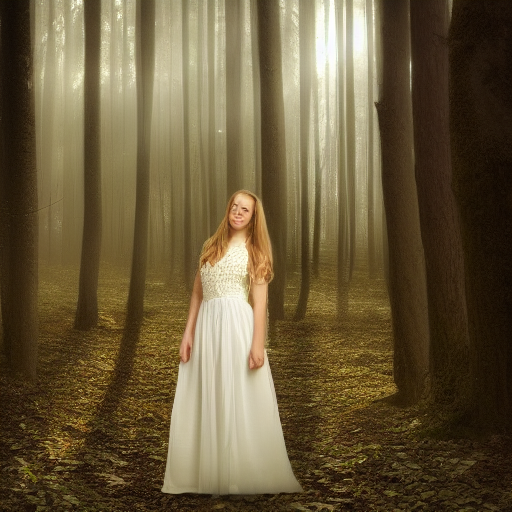

In [30]:
# Display in Notebook
display(generated_image)

# Save to disk
generated_image.save("my_sd_implementation_output.png")

---
## Running Comparison tests VISUALLY section 1

In [31]:
def compare_pipelines(prompt, steps=50):
    hf_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        use_safetensors=True,
    ).to("cuda")

    hf_pipe.scheduler=DDPMScheduler.from_config(hf_pipe.scheduler.config) #swapped DDPMS scheduler from the previous PDNM

    generator = torch.Generator("cuda").manual_seed(seed)
    hf_image = hf_pipe(
        prompt, 
        num_inference_steps=steps, 
        guidance_scale=cfg_scale,
        generator=generator
    ).images[0]

    del hf_pipe
    torch.cuda.empty_cache()

    custom_pixels = inference(
        prompt=prompt, 
        uncond_prompt="", 
        input_image=None, 
        strength=1.0, 
        do_cfg=True, 
        cfg_scale=cfg_scale, 
        sampler_name="ddpm", 
        n_inference_steps=steps, 
        models=models, 
        device="cuda", 
        idle_device="cpu", 
        tokenizer=tokenizer
    )
    
    custom_image = Image.fromarray(custom_pixels)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(hf_image)
    axs[0].set_title("HuggingFace", fontsize=14)
    axs[0].axis("off")
    
    axs[1].imshow(custom_image)
    axs[1].set_title("DeepLure Custom", fontsize=14)
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()

    output_dir = "comparisons"
    os.makedirs(output_dir, exist_ok=True)

    safe_prompt = "".join([c for c in prompt[:60] if c.isalnum() or c in " -_"]).strip()
    safe_prompt = safe_prompt.replace(" ", "_")
    filename = f"{safe_prompt}.png"
    save_path = os.path.join(output_dir, filename)

    dst = Image.new('RGB', (hf_image.width + custom_image.width, hf_image.height))
    dst.paste(hf_image, (0, 0))
    dst.paste(custom_image, (hf_image.width, 0))

    dst.save(save_path)
    print("Image saved")

    return hf_image, custom_image

---
## Running Comparison tests ANALYTICALLY section 2

In [32]:
def compare_analytically(hg_img, cst_img):
    img1=np.array(hg_img)
    img2=np.array(cst_img)

    mse=np.mean((img1-img2)**2)

    if mse==0:
        psnr=float('inf')
    else:
        pixel_mask=255.0
        psnr=20*np.log10(pixel_mask/np.sqrt(mse))

    ssim_val=ssim(img1, img2, channel_axis=-1, data_range=255)
    return mse, psnr, ssim_val

---
# Final Comparison Class

In [33]:
def compare(prompt):
    hf, custom=compare_pipelines(prompt)
    mse, psnr, ssim_val=compare_analytically(hf, custom)
    
    return {
        "mse":mse, 
        "psnr":psnr, 
        "ssim": ssim_val
    }

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


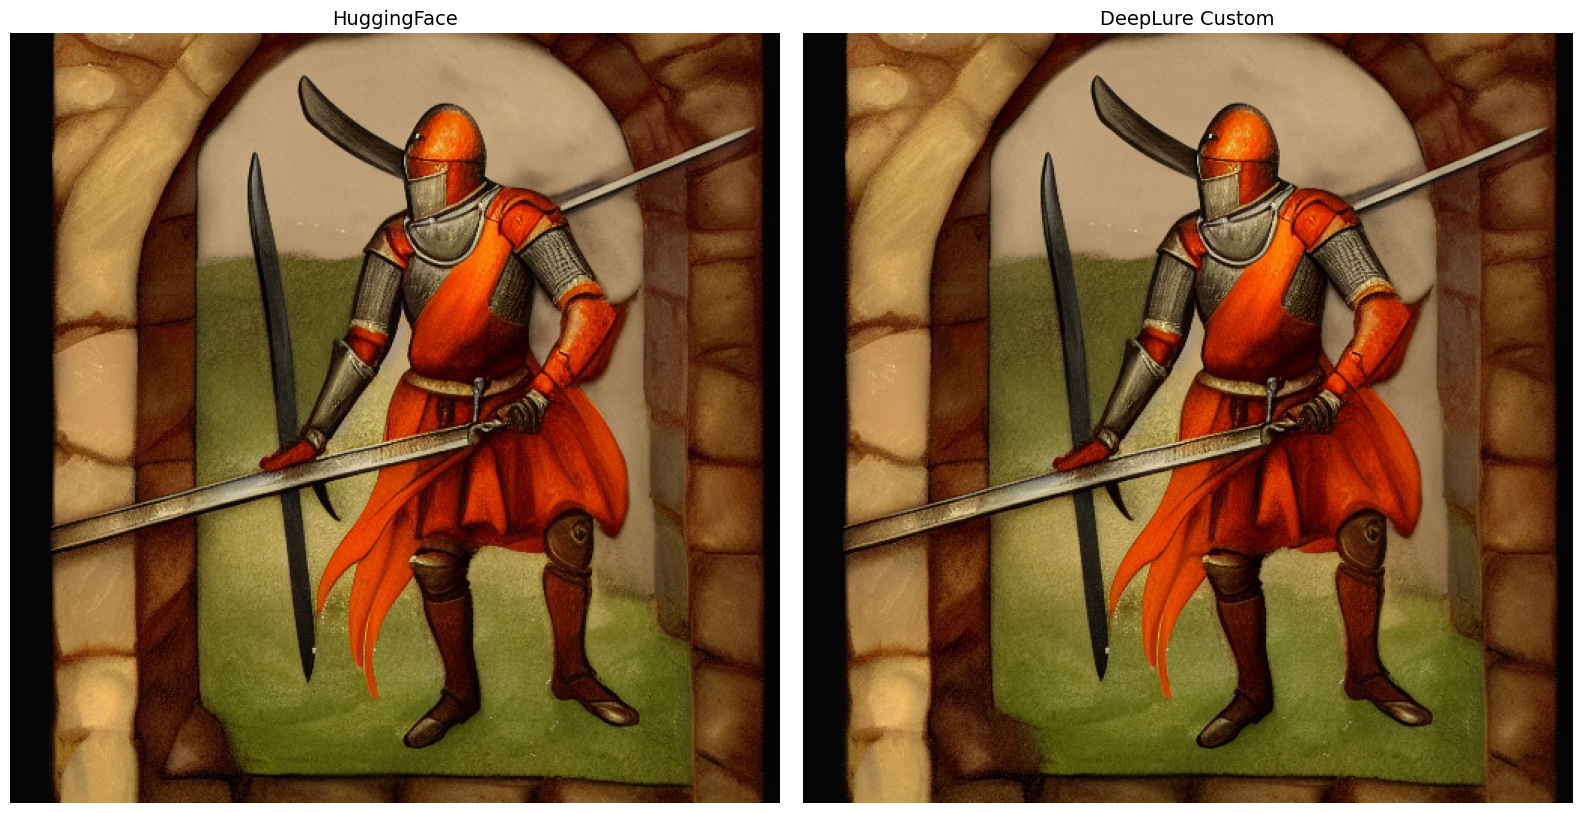

Image saved
{'mse': np.float64(14.98013432820638), 'psnr': np.float64(36.375646531294805), 'ssim': np.float64(0.9464731950224974)}


In [34]:
print(compare("A medieval knight wielding a fiery sword."))

---
## REFERENCES
Post completition of the task, I utilised
1. https://arxiv.org/pdf/2006.11239
2. https://arxiv.org/pdf/2112.10752
3. https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5/tree/main
4. https://github.com/ES7/Stable-Diffusion-from-Scratch/blob/main/Stable_Diffusion/model_converter.py
5. https://github.com/CompVis/stable-diffusion

---
rough work, checking and fixing problems

In [35]:
# #checking keys
# from diffusers import StableDiffusionPipeline

# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     torch_dtype=torch.float32
# )

# vae_keys = [k for k in pipe.vae.state_dict().keys() if 'encoder' in k]
# for k in vae_keys:
#     print(k)

# your_encoder = VAE_Encoder()
# for k in list(your_encoder.state_dict().keys()):
#     print(k)

# for k in list(pipe.unet.state_dict().keys()):
#     print(k)

# your_diff = Diffusion()
# for k in list(your_diff.state_dict().keys()):
#     print(k)

In [36]:
# from model_loader import preload_models_from_standard_weights
# import torch

# # 1. Load the raw dictionaries (Don't load into models yet)
# from model_loader import load_from_standard_weights
# print("Loading raw weights...")
# state_dicts = load_from_standard_weights("runwayml/stable-diffusion-v1-5", device="cpu")

# # 2. Initialize just the Diffusion model
# print("Initializing Diffusion...")
# # Ensure you import Diffusion class correctly
# diff_model = Diffusion()

# # 3. Compare Keys
# model_keys = set(diff_model.state_dict().keys())
# loaded_keys = set(state_dicts['diffusion'].keys())

# missing = list(model_keys - loaded_keys)
# unexpected = list(loaded_keys - model_keys)

# print(f"\n=== DEBUG REPORT ===")
# print(f"Missing Keys: {len(missing)}")
# print(f"Unexpected Keys: {len(unexpected)}")

# print("\n--- First 5 Missing Keys (What the model wants but didn't get) ---")
# for k in sorted(missing):
#     print(k)

# print("\n--- First 5 Unexpected Keys (What you generated but the model rejected) ---")
# for k in sorted(unexpected):
#     print(k)

In [37]:
# import torch
# from PIL import Image

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# models['decoder'].to(DEVICE)

# # 2. Generate pure random noise (Latents) on GPU
# test_latents = torch.randn((1, 4, 64, 64), device=DEVICE)

# print("Running VAE Decoder...")
# with torch.no_grad():
#     decoded_test = models['decoder'](test_latents)

# # 4. Process and Display
# print("Converting to image...")
# decoded_test = rescale(decoded_test, (-1, 1), (0, 255), clamp=True)
# decoded_test = decoded_test.permute(0, 2, 3, 1).cpu().numpy().astype("uint8")
# display(Image.fromarray(decoded_test[0]))

# ### GENERATED PURE COLOURED RANDOM NOISE

---
Notes:
1. First try just received plain grey noise on inference (fixed Inference function)
    - latent tensors exploding to infinity
    - clamped latents to between -5 to 5
    - stopped immediately if NaN generation

2. Second try produced deep fried red/black noise with figure vaguely visible
    - Found typo in scheduler
    - used alpha instead of beta i.e a 1 instead of a 0
    - used correct equation from the paper